In this exercise, you are going to perform simple fine tuning, teaching a pretrained version of resnet18 to tell ants from bees.

In [2]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.0.0+cu118
Torchvision Version:  0.15.1+cpu


In [1]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
#!unzip hymenoptera_data.zip



--2023-10-10 09:03:03--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.173.5.55, 18.173.5.90, 18.173.5.17, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.173.5.55|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: 'hymenoptera_data.zip.3'

     0K .......... .......... .......... .......... ..........  0% 2.36M 19s
    50K .......... .......... .......... .......... ..........  0% 5.03M 14s
   100K .......... .......... .......... .......... ..........  0% 4.97M 12s
   150K .......... .......... .......... .......... ..........  0% 7.60M 11s
   200K .......... .......... .......... .......... ..........  0% 19.9M 9s
   250K .......... .......... .......... .......... ..........  0% 9.45M 8s
   300K .......... .......... .......... .......... ..........  0% 20.9M 7s
   350K .......... .......... .......... .......... ..........  0%

In [3]:
data_dir = "./data/hymenoptera_data"

num_classes = 2
batch_size = 8
num_epochs = 15


In [4]:
# Data augmentation and normalization for training
# Just normalization for validation

input_size = 224 #this value matches resnet18


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}

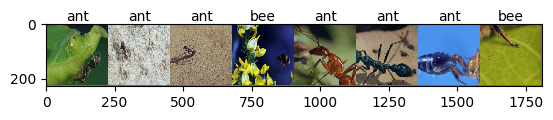

In [6]:
#Let's print some examples:

it = iter(dataloaders_dict['train'])
images,labels = next(it)

grid=torchvision.utils.make_grid(images)

import matplotlib.pyplot as plt

def show(imgGrid,labels,types):
    nImg=len(labels)
    npimg = imgGrid.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')

    plotx=np.linspace(0,npimg.shape[2],nImg+1)
    plotx=np.diff(plotx)/2+plotx[:len(plotx)-1]
    [plt.text(plotx[i],0,types[labels.numpy()[i]],ha='center',va='bottom') for i in range(nImg)]


gridMin=np.min(grid.numpy())
gridMax=np.max(grid.numpy())
show((grid-gridMin)/(gridMax-gridMin),labels,('ant','bee'))



The next cell is  the only one not filled in already.

Experiment with a few different setups:

- try loading with 'pretrained=False', and see what performance you can get.
- try changing to 'pretrained=True', and see  the difference.
- try freezing and unfreezing different layers and see what it does to your accuracy

You can get the names of different layers by just printing the model.


In [19]:
#load model and set up for fine tuning:
model_ft = models.resnet18(pretrained=True)

# optionally freeze parameters
for param in model_ft.parameters():
    param.requires_grad = False
# overwrite the 'fc' layer
num_features = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_features, num_classes)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using: ', device)
# Send the model to GPU
model_ft.to(device)
# find parameters to update
params_to_update = []
#(loop over "name,param in model_ft.named_parameters()" and append to params_to_update if requires_grad==True)
for name, param in model_ft.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
# Set up optimizer for non-frozen parameters
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Using:  cuda:0
	 fc.weight
	 fc.bias


c:\Users\Jens\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Jens\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [20]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []
    train_acc_history=[]

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    #evaluate before training:
    model.eval()   # Set model to evaluate mode

    running_corrects = 0
    for inputs, labels in dataloaders['train']:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)

      running_corrects += torch.sum(preds == labels.data)

    acc = running_corrects.double() / len(dataloaders['train'].dataset)
    train_acc_history.append(acc)
    print('train acc:',acc)

    running_corrects = 0
    for inputs, labels in dataloaders['val']:
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      running_corrects += torch.sum(preds == labels.data)

    acc = running_corrects.double() / len(dataloaders['val'].dataset)
    val_acc_history.append(acc)
    print('val acc:',acc)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                train_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history

In [21]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist_val, hist_train = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

train acc: tensor(0.4467, device='cuda:0', dtype=torch.float64)
val acc: tensor(0.5163, device='cuda:0', dtype=torch.float64)
Epoch 0/14
----------
train Loss: 0.6435 Acc: 0.6148
val Loss: 0.2713 Acc: 0.9346

Epoch 1/14
----------
train Loss: 0.3738 Acc: 0.8074
val Loss: 0.2024 Acc: 0.9608

Epoch 2/14
----------
train Loss: 0.3180 Acc: 0.8770
val Loss: 0.2539 Acc: 0.9150

Epoch 3/14
----------
train Loss: 0.3110 Acc: 0.8770
val Loss: 0.1906 Acc: 0.9346

Epoch 4/14
----------
train Loss: 0.2875 Acc: 0.8811
val Loss: 0.2307 Acc: 0.9216

Epoch 5/14
----------
train Loss: 0.2638 Acc: 0.9016
val Loss: 0.2102 Acc: 0.9281

Epoch 6/14
----------
train Loss: 0.2567 Acc: 0.8934
val Loss: 0.1801 Acc: 0.9477

Epoch 7/14
----------
train Loss: 0.2372 Acc: 0.9057
val Loss: 0.2009 Acc: 0.9412

Epoch 8/14
----------
train Loss: 0.2681 Acc: 0.8811
val Loss: 0.1967 Acc: 0.9281

Epoch 9/14
----------
train Loss: 0.2432 Acc: 0.8975
val Loss: 0.1968 Acc: 0.9346

Epoch 10/14
----------
train Loss: 0.3024 Ac

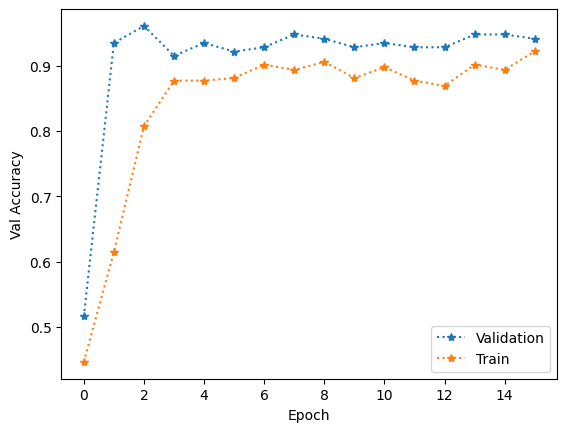

In [22]:
import matplotlib.pyplot as plt

accs=[x.cpu().numpy() for x in hist_val]
accs=np.array(accs)
plt.plot(accs,':*')
plt.xlabel('Epoch')
plt.ylabel('Val Accuracy')

accs=[x.cpu().numpy() for x in hist_train]
accs=np.array(accs)
plt.plot(accs,':*')

plt.legend(['Validation','Train'])
